## Quick Start Tutorial for the Better Oscillation Detection Method
This tutorial provides a brief example for using CML's P_episode package for detecting true oscillations in electrophysiological data.
The method is adapted from Caplan Et Al (2001), *Distinct Patterns of Brain Oscillations Underlie Two Basic Parameters of Human Maze Learning*

In [1]:
import sys
sys.path.append('/home1/jrudoler/src/cmlcode/BOSC/') 
import numpy as np
import pandas as pd
import cmlreaders as cml
import P_episode as pep
import scipy.stats as scp
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from ptsa.data.filters import ButterworthFilter
import warnings
warnings.simplefilter('ignore')

/home1/jrudoler/anaconda3/envs/cml37/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


Pick a subject, create a CMLReader object, and use it to load events and electrode configurations

In [2]:
subject = 'R1195E'
method = 'bip'
reader = cml.CMLReader(subject = subject, experiment = 'FR1', session = 0)
pairs = reader.load("pairs")
all_events = reader.load('task_events')

Use events and electrodes to load EEG (in this case, bipolar) for a single electrode pair.

In [3]:
bip = reader.load_eeg(scheme = pairs[pairs.label =='5LD3-5LD4']).to_ptsa().mean(['event', 'channel'])
bip = ButterworthFilter(bip, freq_range=[58., 62.], filt_type='stop', order=4).filter()

#### P_episode Class:  
##### Initialization arguments:
**events**- a pandas DataFrame containing the event or events (from the same session) being analyzed  
**eeg** - a ptsa timeseries object containing EEG data. Should contain data for ONE ELECTRODE ONLY, and therefore should not have a "channel" dimension. Should contain contiguous EEG for an entire session  
**event_type** - 'WORD' for encoding, 'REC_WORD' for retrieval.  
**relstart** - beginning of event in ms relative to word onset  
**relstop** - end of event in ms relative to word onset  
**width** - the length of the MorletWaveletFilter  
**sr** - the sample rate for the EEG signal. If none, it uses CMLReader to find it   
**lowfreq** - the lowest frequency to be calculated  
**highfreq** - the highest frequency to be calculated  
**numfreqs** - the number of frequencies logspaced between lowfreq and highfreq to be calculated  
**percentthresh** - Percentile (default 95th) of chi-squared distribution of powers. Describes how much power is deemed a significant oscillation.   
**numcyclesthresh** - how many cycles the power threshold must last to be considered significant. 3 by default  

Initialize a P_episode class object, which will automatically perform wavelet decomposition. 

In [4]:
bosc = pep.P_episode(all_events, bip, event_type='WORD', relstart = 300, relstop = 1301, width=5, sr=bip.samplerate.values, 
                     lowfreq=2, highfreq=120, numfreqs=30, percentthresh=.95, numcyclesthresh=3)

CPP total time wavelet loop:  4.416383266448975


BOSC seeks to identify true oscillatory behavior by subtracting out the background 1/f spectrum. Visualize the background fit with built in method background_fit(). The plot_type parameter allows you to either specify a list index to plot or to average over all lists in the session (and report the average $R^2$ metric)

0.98717829131228

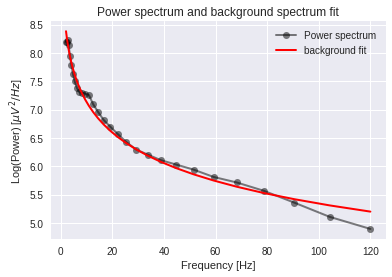

In [6]:
bosc.background_fit('list', 0)

0.98717829131228
0.9869521691850087
0.9889795264088749
0.9896466186724112
0.9913854052109363
0.9894468855082738
0.9855818903856751
0.9907791462638375
0.9933045473905867
0.9914553937334848


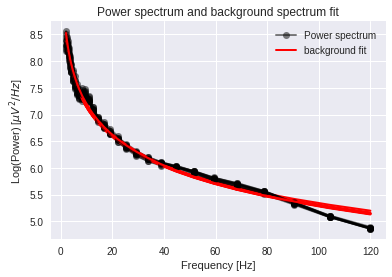

In [7]:
for i in range(10):
    r2 = bosc.background_fit('list', i)
    print(r2)

0.989637461073033

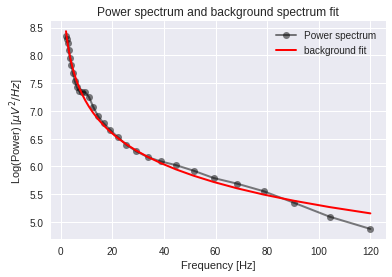

In [8]:
bosc.background_fit('session')

You can also view the EEG trace with true oscillatory periods highlighted in red. The raw_trace() method takes a frequency *index* as a required argument. You can access the available frequencies with bosc.freqs. 

In [9]:
bosc.freqs.round(2)

array([  2.  ,   2.3 ,   2.65,   3.05,   3.52,   4.05,   4.67,   5.37,
         6.19,   7.13,   8.21,   9.45,  10.88,  12.54,  14.44,  16.63,
        19.15,  22.05,  25.39,  29.24,  33.68,  38.78,  44.67,  51.44,
        59.24,  68.22,  78.57,  90.48, 104.2 , 120.  ])

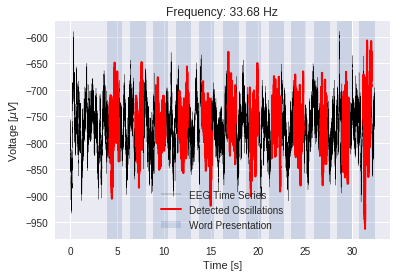

In [11]:
bosc.raw_trace(freq_idx=20, list_idx=0)

Zooming in on a region of interest is easy enough with plt.xlim(start, end)

(5, 10)

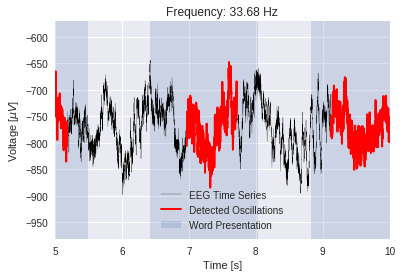

In [12]:
bosc.raw_trace(20)
plt.xlim(5, 10)

To see the signal filtered, which is a bit more intuitive, use the 'filtered' parameter

CPP total time wavelet loop:  4.184603691101074


(5, 10)

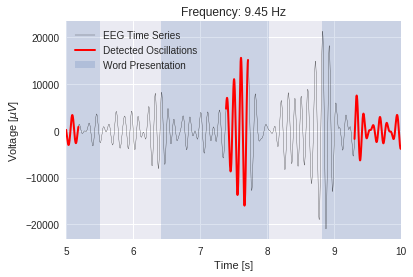

In [13]:
bosc.raw_trace(11, filtered = True)
plt.xlim(5, 10)

Now we can calculate p_episode averaged for all events of interest, for recalled events, for non-recalled events, and ttest scores comparing recalled and not-recalled

### Calculating P-episode across events
##### calc_subj_pep:
Arguments:  
**subj** - subject string  
**elecs** - list of electrode pairs (strings)  
**method** - bip or avg depending on referencing scheme  
**freq_specs** - tuple of (low_freq, high_freq, num_freqs) for background fitting in BOSC. To be logarithmically spaced.

In [14]:
pep_all, pep_rec, pep_nrec, t = pep.calc_subj_pep(subject, ['5LD3-5LD4'], load_eeg= True, eeg_path= '/home1/jrudoler/Saved_files/bosc_referencing/'+subject+'/'+method+'/eeg/', save_eeg= False, save_result= False)

Subject:  R1195E
['5LD3-5LD4']
Loading session 0 EEG
CPP total time wavelet loop:  4.667529344558716
0.28
(30,)
Loading session 1 EEG
CPP total time wavelet loop:  3.6371848583221436
0.2733333333333333
(2, 30)
Loading session 2 EEG
CPP total time wavelet loop:  3.9564850330352783
0.30444444444444446
(3, 30)
3 sessions
900 total events: 274 recalled and 626 non-recalled


Plot one subject's P_episode averaged over events across the frequency spectrum

(0, 30)

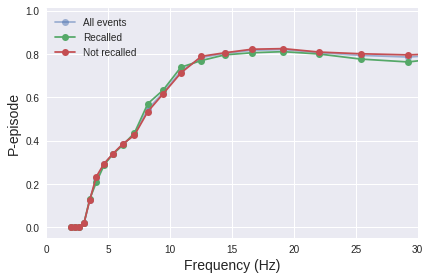

In [15]:
pep.plot_pepisode(pep_all, pep_rec, pep_nrec)
plt.xlim(0, 30)